# MOUNT GOOGLE DRIVE  

In [1]:
from google.colab import drive
from pathlib import Path
import os

# Connect Google Drive
drive.mount('/content/drive')

DRIVE_PROJECT_PATH = '/content/drive/MyDrive/RobustClassifierProject'

# This ensures that your program can save the checkpoint
Path(DRIVE_PROJECT_PATH).mkdir(exist_ok=True)

print(f"Drive mounted. Files will be saved permanently in: {DRIVE_PROJECT_PATH}")

Mounted at /content/drive
Drive mounted. Files will be saved permanently in: /content/drive/MyDrive/RobustClassifierProject


In [ ]:
import os
import random
import numpy as np
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets, models, utils
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torchvision.datasets as datasets
import torchvision.transforms as transforms

import torch.nn as nn


# Standard normalization parameters for CIFAR-10 dataset
CIFAR_MEAN = [0.4914, 0.4822, 0.4465]
CIFAR_STD = [0.2023, 0.1994, 0.2010]
NUM_CLASSES = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Path('robust_classifier_project_output').mkdir(exist_ok=True)

def cleanup_checkpoints(model_name):
    """Deletes old checkpoints to start training a new model."""
    path = f'robust_classifier_project_output/{model_name}_robust_cifar10.pth'
    if os.path.exists(path):
        os.remove(path)
        print(f"Old checkpoint deleted: {path}")

# Run cleanup
cleanup_checkpoints('mobilenet_v2')
cleanup_checkpoints('resnet50')

print(f"Setup complete. Using device: {DEVICE}")

Setup complete. Using device: cuda


#  ARGS CLASS - Configuration (ResNet-18)

In [ ]:

class Args:
    """Project configuration arguments."""
    def __init__(self):
        self.model = 'resnet18'
        self.epochs_adv = 100
        self.batch_size = 128
        self.learning_rate = 0.1
        self.image_size = 32
        self.save_dir = '/content/drive/MyDrive/RobustClassifierProject'
        self.checkpoint = f'{self.model}_robust_cifar10.pth'
        self.mode = 'train'
        self.seed = 42

#DATA LOADER - CIFAR-10

def get_cifar10_loader(batch_size, image_size):
    """Loads and returns CIFAR-10 training and test data loaders."""

    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(CIFAR_MEAN, CIFAR_STD),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(CIFAR_MEAN, CIFAR_STD),
    ])

    trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

    testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    return trainloader, testloader, NUM_CLASSES
#MODEL DEFINITION
def build_model(model_name, num_classes):
    """Initializes and configures the classifier model for CIFAR-10 (32x32)."""

    if model_name == 'resnet18':
        model = models.resnet18(weights=None)

        #Change Conv1 for small images (32x32)
        model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

        model.maxpool = nn.Identity()

        # connected layer
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)

    else:
        raise ValueError(f"Model {model_name} not supported CIFAR-10.")

    return model


# CHECKPOINT MANAGEMENT FUNCTIONS


In [ ]:

def load_checkpoint(model, path, device, optimizer=None, scheduler=None):
    """Loads a model state from a path and returns the next epoch number."""
    start_epoch = 0
    if not os.path.exists(path):
        print(f"Checkpoint not found at {path}. Starting from epoch 0.")
        return start_epoch

    try:
        checkpoint_data = torch.load(path, map_location=device)
        model.load_state_dict(checkpoint_data['model_state_dict'])
        start_epoch = checkpoint_data['epoch'] + 1

        if optimizer and 'optimizer_state_dict' in checkpoint_data:
            optimizer.load_state_dict(checkpoint_data['optimizer_state_dict'])
        if scheduler and 'scheduler_state_dict' in checkpoint_data:
            scheduler.load_state_dict(checkpoint_data['scheduler_state_dict'])

        print(f"Successfully loaded model from {path}. Resuming training from epoch {start_epoch}.")
    except Exception as e:
        print(f"Error loading checkpoint: {e}. Starting new training from epoch 0.")
        if os.path.exists(path):
             os.remove(path)
             print("Corrupted checkpoint deleted.")
        return 0

    return start_epoch

def save_checkpoint(epoch, args, model, optimizer, scheduler, path):
    """Saves the current model and training state (epoch, optimizer, scheduler)."""
    print(f"Saving checkpoint at epoch {epoch+1}/{args.epochs_adv} to {path}")
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'args': vars(args)
    }, path)

# CORE ATTACK FUNCTION (PGD - Projected Gradient Descent)

In [ ]:

def generate_adv_examples(model, x, y, epsilon, num_steps, step_size, device):
    """Generates PGD adversarial examples for a batch of inputs."""

    model.eval()
    x_adv = x.detach().clone().to(device) # Clone the original input

    # Random perturbation
    x_adv = x_adv + step_size * torch.randn_like(x_adv).uniform_(-epsilon, epsilon)
    x_adv = torch.clamp(x_adv, x - epsilon, x + epsilon)

    for _ in range(num_steps):
        x_adv.requires_grad_(True)

        # Calculate loss
        output = model(x_adv)
        loss = F.cross_entropy(output, y)

        # Calculate gradient
        grad = torch.autograd.grad(loss, x_adv, retain_graph=False, create_graph=False)[0]

        # Apply step size
        x_adv = x_adv.detach() + step_size * torch.sign(grad)

        #   Clamp within epsilon
        x_adv = torch.min(torch.max(x_adv, x - epsilon), x + epsilon)

        # Assuming the normalized
        for c in range(3):

            max_val = (1.0 - CIFAR_MEAN[c]) / CIFAR_STD[c]
            min_val = (0.0 - CIFAR_MEAN[c]) / CIFAR_STD[c]
            x_adv[:, c, :, :] = torch.clamp(x_adv[:, c, :, :], min_val, max_val)

    model.train() # Return model to training mode
    return x_adv.detach()

def train_adversarial(args, train_loader, test_loader, num_classes, device):
    """
    Trains the classifier adversarially robustly using PGD, with checkpointing.
    """

    #   Model and Optimizer Setup
    model = build_model(args.model, num_classes).to(device)
    optimizer = optim.SGD(model.parameters(), lr=args.learning_rate, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs_adv)

    # Load Checkpoint
    checkpoint_path = os.path.join(args.save_dir, args.checkpoint)
    start_epoch = load_checkpoint(model, checkpoint_path, device, optimizer, scheduler)

    # PGD parameters for adversarial training
    epsilon = 8 / 255 / 0.2
    num_steps = 7
    step_size = 2 / 255 / 0.2

    print(f"Starting Robust Training ({args.model}) from epoch {start_epoch} / {args.epochs_adv}...")

    # 3. Training Loop
    for epoch in range(start_epoch, args.epochs_adv):
        model.train()
        total_loss = 0
        tqdm_loader = tqdm(train_loader, desc=f"Epoch {epoch+1}/{args.epochs_adv}")

        for batch_idx, (data, target) in enumerate(tqdm_loader):
            data, target = data.to(device), target.to(device)

            adv_data = generate_adv_examples(model, data, target, epsilon, num_steps, step_size, device)

            optimizer.zero_grad()

            # Forward pass
            output = model(adv_data)
            loss = F.cross_entropy(output, target)

            # Backward and Optimize
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Update TQDM description
            avg_loss = total_loss / (batch_idx + 1)
            tqdm_loader.set_postfix(loss=f'{avg_loss:.3f}')

        scheduler.step()

        #  Save Checkpoint
        if (epoch + 1) % 20 == 0 or (epoch + 1) == args.epochs_adv:
            save_checkpoint(epoch, args, model, optimizer, scheduler, checkpoint_path)

    return model

# IMAGE SYNTHESIS

In [ ]:
# Un-normalize
def denormalize(image_tensor, mean=CIFAR_MEAN, std=CIFAR_STD):
    for t, m, s in zip(image_tensor, mean, std):
        t.mul_(s).add_(m)
    return torch.clamp(image_tensor, 0, 1)

def generate_image_synthesis(model, class_idx, num_samples, num_steps, device):
    """
    Generates images by maximizing the class score of the robust classifier.
    """
    model.eval()

    # Initialize with random noise
    img_size = args.image_size

    # normalized space / essential for PGD
    init_noise = torch.randn(num_samples, 3, img_size, img_size, device=device) * 0.1
    # Ensure noise
    for c in range(3):
        max_val = (1.0 - CIFAR_MEAN[c]) / CIFAR_STD[c]
        min_val = (0.0 - CIFAR_MEAN[c]) / CIFAR_STD[c]
        init_noise[:, c, :, :] = torch.clamp(init_noise[:, c, :, :], min_val, max_val)

    x = init_noise.requires_grad_(True)

    #  the target class index for all samples
    target = torch.full((num_samples,), class_idx, device=device, dtype=torch.long)

    # The original paper suggests small step size for smoother images
    step_size = 0.01

    print(f"Generating {num_samples} image(s) for class: {class_idx}...")

    # Optimization loop (PGD for maximizing score)
    for i in tqdm(range(num_steps)):
        output = model(x)

        loss = -output[:, class_idx].mean()

        model.zero_grad()
        loss.backward()

        grad = x.grad.data
        x.data = x.data - step_size * grad.sign() # for PGD-like

        for c in range(3):
            max_val = (1.0 - CIFAR_MEAN[c]) / CIFAR_STD[c]
            min_val = (0.0 - CIFAR_MEAN[c]) / CIFAR_STD[c]
            x.data[:, c, :, :] = torch.clamp(x.data[:, c, :, :], min_val, max_val)

        x.grad.data.zero_()

    generated_images = denormalize(x.detach().cpu())

    # Display the result
    fig = plt.figure(figsize=(12, 12))
    grid = utils.make_grid(generated_images, nrow=int(np.sqrt(num_samples)), padding=2, normalize=False)
    plt.imshow(grid.permute(1, 2, 0))
    plt.title(f"Generated Images for Class {class_idx}")
    plt.axis('off')
    plt.show()

    return generated_images


# MAIN EXECUTION FUNCTION


In [ ]:
def run_project(args):
    """Main function to run the project."""

    print(f" Running Project with Model: {args.model}")

    # Set seed
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)

    # Load data
    train_loader, test_loader, num_classes = get_cifar10_loader(args.batch_size, args.image_size)

    if args.mode == 'train':
        print(f"Mode: TRAINING for {args.epochs_adv} epochs.")
        # training of ResNet-18
        robust_model = train_adversarial(args, train_loader, test_loader, num_classes, DEVICE)

        # After training,
        print("\n Training complete")

    elif args.mode == 'generate':
        print("Mode: IMAGE GENERATION DEMO.")

        #  trained model
        model = build_model(args.model, num_classes).to(DEVICE)
        checkpoint_path = os.path.join(args.save_dir, args.checkpoint)

        # Quick load
        load_checkpoint(model, checkpoint_path, DEVICE)

        # 2000 steps are used for high quality generation
        generate_image_synthesis(model, class_idx=1, num_samples=9, num_steps=2000, device=DEVICE)

        #   Generate 9 images
        generate_image_synthesis(model, class_idx=9, num_samples=9, num_steps=2000, device=DEVICE)

    else:
        print(f"Unknown mode: {args.mode}. Set to 'train' or 'generate'.")


# RUN
args = Args()
run_project(args)

 Running Project with Model: resnet18


100%|██████████| 170M/170M [00:05<00:00, 30.9MB/s]


Mode: TRAINING for 100 epochs.
Successfully loaded model from /content/drive/MyDrive/RobustClassifierProject/resnet18_robust_cifar10.pth. Resuming training from epoch 80.
Starting Robust Training (resnet18) from epoch 80 / 100...


Epoch 100/100: 100%|██████████| 391/391 [03:45<00:00,  1.74it/s, loss=0.329]


Saving checkpoint at epoch 100/100 to /content/drive/MyDrive/RobustClassifierProject/resnet18_robust_cifar10.pth

 Training complete



#CONFIGURATION AND GLOBAL PARAMETERS


In [15]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CIFAR-10 Normalization
CIFAR_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR_STD = (0.2023, 0.1994, 0.2010)
CIFAR_LABELS = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Model Checkpoint Path
DRIVE_PROJECT_PATH = '/content/drive/MyDrive/RobustClassifierProject'
CHECKPOINT_FILENAME = 'resnet18_robust_cifar10.pth'
CHECKPOINT_PATH = os.path.join(DRIVE_PROJECT_PATH, CHECKPOINT_FILENAME)

# PGD Synthesis Parameters
NUM_STEPS = 100
STEP_SIZE = 0.01



# RESNET-18 ARCHITECTURE DEFINITION  


In [16]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.downsample = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.downsample(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.fc = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

def build_model():
    return ResNet(BasicBlock, [2, 2, 2, 2])



# HELPER UTILITY FUNCTIONS  


In [17]:


def denormalize(x):
    """Converts normalized tensor back to [0, 1] range."""
    x_device = x.device
    x_cpu = x.cpu()
    mean = torch.tensor(CIFAR_MEAN).view(3, 1, 1)
    std = torch.tensor(CIFAR_STD).view(3, 1, 1)
    return (x_cpu * std + mean).to(x_device)

def downsample_cifar(x):
    """Downsamples image for Super-Resolution consistency loss."""
    return F.avg_pool2d(x, kernel_size=2, stride=2)

def show_images(original_img, synthesized_img, corrupted_img=None, title="Synthesized Result"):
    """Displays image results using Matplotlib."""

    if corrupted_img is not None:
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        titles = ["Original/Source", "Corrupted/Input", title]
        images = [original_img, corrupted_img, synthesized_img]
    else:
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        titles = ["Original/Input", title]
        images = [original_img, synthesized_img]

    for i, img in enumerate(images):
        img_np = img.permute(1, 2, 0).cpu().numpy()
        img_np = np.clip(img_np, 0, 1)
        ax[i].imshow(img_np)
        ax[i].set_title(titles[i])
        ax[i].axis('off')

    plt.tight_layout()
    plt.show()



# IMAGE SYNTHESIS FUNCTIONS (5 TASKS)


In [18]:
def generate_inpainting_result(model, x_original, mask, target_label_idx, lambda_reg, num_steps, step_size, device):
    """Task 1: Image Inpainting (Restore corrupted image)"""
    model.eval()
    x_adv = x_original.detach().clone().to(device)
    x_unnorm = denormalize(x_adv)
    random_init = torch.rand_like(x_unnorm).to(device)
    x_unnorm_init = x_unnorm * (1 - mask.to(device)) + random_init * mask.to(device)

    mean_tensor_dev = torch.tensor(CIFAR_MEAN, device=device).view(3, 1, 1)
    std_tensor_dev = torch.tensor(CIFAR_STD, device=device).view(3, 1, 1)
    x_adv.data = (x_unnorm_init.to(device) - mean_tensor_dev) / std_tensor_dev

    target_label = torch.tensor([target_label_idx], device=device).repeat(x_adv.size(0))

    for _ in tqdm(range(num_steps), desc="Inpainting PGD"):
        x_adv.requires_grad_(True)
        output = model(x_adv)
        loss_score = F.cross_entropy(output, target_label)
        loss_reg = torch.norm((x_original - x_adv) * (1 - mask.to(device)), p=2) # Preserve unmasked regions
        total_loss = loss_score + lambda_reg * loss_reg
        grad = torch.autograd.grad(total_loss, x_adv, retain_graph=False, create_graph=False)[0]
        x_adv = x_adv.detach() - step_size * torch.sign(grad)
        x_adv.data = x_adv.data * mask.to(device) + x_original.data * (1 - mask.to(device))
    return x_adv.detach()

def generate_translation_result(model, x_source, target_label_idx, epsilon, num_steps, step_size, device):
    """Task 2: Image-to-Image Translation (Large Epsilon Adversarial Attack)"""
    model.eval()
    x = x_source.detach().clone().to(device)
    x_adv = x.detach().clone()
    x_min = x - epsilon
    x_max = x + epsilon
    target_label = torch.tensor([target_label_idx] * x_adv.size(0), device=device)

    for _ in tqdm(range(num_steps), desc=f"Translation PGD to Class {target_label_idx}"):
        x_adv.requires_grad_(True)
        output = model(x_adv)
        loss = F.cross_entropy(output, target_label)
        grad = torch.autograd.grad(loss, x_adv, retain_graph=False, create_graph=False)[0]
        x_adv = x_adv.detach() - step_size * torch.sign(grad)
        x_adv = torch.min(torch.max(x_adv, x_min), x_max)
    return x_adv.detach()

def generate_super_resolution_result(model, x_low_res, target_label_idx, lambda_reg, num_steps, step_size, device):
    """Task 3: Super-Resolution (Generate HR image consistent with LR input)"""
    model.eval()
    x_start = F.interpolate(x_low_res.detach().clone(), scale_factor=2, mode='bilinear', align_corners=False).to(device)
    x_adv = x_start.detach().clone()
    target_label = torch.tensor([target_label_idx], device=device).repeat(x_adv.size(0))

    for _ in tqdm(range(num_steps), desc="Super-Resolution PGD"):
        x_adv.requires_grad_(True)
        output = model(x_adv)
        loss_score = F.cross_entropy(output, target_label)
        x_adv_down = downsample_cifar(x_adv)
        loss_reg = torch.norm(x_adv_down - x_low_res.to(device), p=2) # Consistency regularization
        total_loss = loss_score + lambda_reg * loss_reg
        grad = torch.autograd.grad(total_loss, x_adv, retain_graph=False, create_graph=False)[0]
        x_adv = x_adv.detach() - step_size * torch.sign(grad)
    return x_adv.detach()

def generate_adversarial_example(model, x_original, target_label_idx, epsilon, num_steps, step_size, device):
    """Task 4: Generative Adversarial Example (Small Epsilon Targeted Attack)"""
    model.eval()
    x = x_original.detach().clone().to(device)
    x_adv = x.detach().clone()
    x_min = x - epsilon
    x_max = x + epsilon
    target_label = torch.tensor([target_label_idx] * x_adv.size(0), device=device)

    for _ in tqdm(range(num_steps), desc=f"Adv. Example to Class {target_label_idx}"):
        x_adv.requires_grad_(True)
        output = model(x_adv)
        loss = F.cross_entropy(output, target_label)
        grad = torch.autograd.grad(loss, x_adv, retain_graph=False, create_graph=False)[0]
        x_adv = x_adv.detach() - step_size * torch.sign(grad)
        x_adv = torch.min(torch.max(x_adv, x_min), x_max)
    return x_adv.detach()

def generate_random_sample(model, target_label_idx, num_steps, step_size, device, init_type='random'):
    """Task 5: Random Samples (Unconditional Generation based on maximizing score)"""
    model.eval()

    if init_type == 'random':
        x_adv = torch.randn((1, 3, 32, 32), device=device).detach().clone()
    else:
        x_adv = torch.zeros((1, 3, 32, 32), device=device).detach().clone()

    target_label = torch.tensor([target_label_idx] * x_adv.size(0), device=device)

    for _ in tqdm(range(num_steps), desc=f"Random Sample for Class {target_label_idx}"):
        x_adv.requires_grad_(True)
        output = model(x_adv)
        loss = -F.cross_entropy(output, target_label) # Minimize negative loss to maximize score
        grad = torch.autograd.grad(loss, x_adv, retain_graph=False, create_graph=False)[0]
        x_adv = x_adv.detach() - step_size * torch.sign(grad)
        x_adv = torch.clamp(x_adv, min=-2.5, max=2.5)

    return x_adv.detach()



# MODEL LOADING AND EXECUTION BLOCK


In [19]:

model = build_model().to(DEVICE)

try:
    print(f"Attempting to load model from: {CHECKPOINT_PATH}")
    checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE)

    state_dict = checkpoint.get('model_state_dict', checkpoint)

    # Clean output
    if 'model_state_dict' in checkpoint or 'state_dict' in checkpoint:
        print("Loading weights detected in nested dictionary.")
    else:
        print("Loading weights from raw state dictionary.")

    model.load_state_dict(state_dict)
    model.eval()
    print("Model loaded successfully. ")

except Exception as e:
    print(f"\n loading failed! {e}")
    raise RuntimeError("Model initialization failed ")


# Load Sample Data ---
transform_test = transforms.Compose([transforms.ToTensor()])
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

sample_index = 10 # Sample index for demonstration
x_sample_unnorm, y_sample_label = testset[sample_index]
y_sample_idx = y_sample_label

mean_tensor_dev = torch.tensor(CIFAR_MEAN).view(3, 1, 1).to(DEVICE)
std_tensor_dev = torch.tensor(CIFAR_STD).view(3, 1, 1).to(DEVICE)
x_sample_norm = ((x_sample_unnorm.to(DEVICE) - mean_tensor_dev) / std_tensor_dev).unsqueeze(0)

print(f"\n Original Sample Image: {CIFAR_LABELS[y_sample_idx]} (Class Index: {y_sample_idx}) ---")



Attempting to load model from: /content/drive/MyDrive/RobustClassifierProject/resnet18_robust_cifar10.pth
Loading weights detected in nested dictionary.
Model loaded successfully. 

 Original Sample Image: airplane (Class Index: 0) ---



# EXECUTE ALL 5 SYNTHESIS TASKS  


## 1. Image Inpainting

Inpainting PGD: 100%|██████████| 100/100 [00:00<00:00, 183.82it/s]


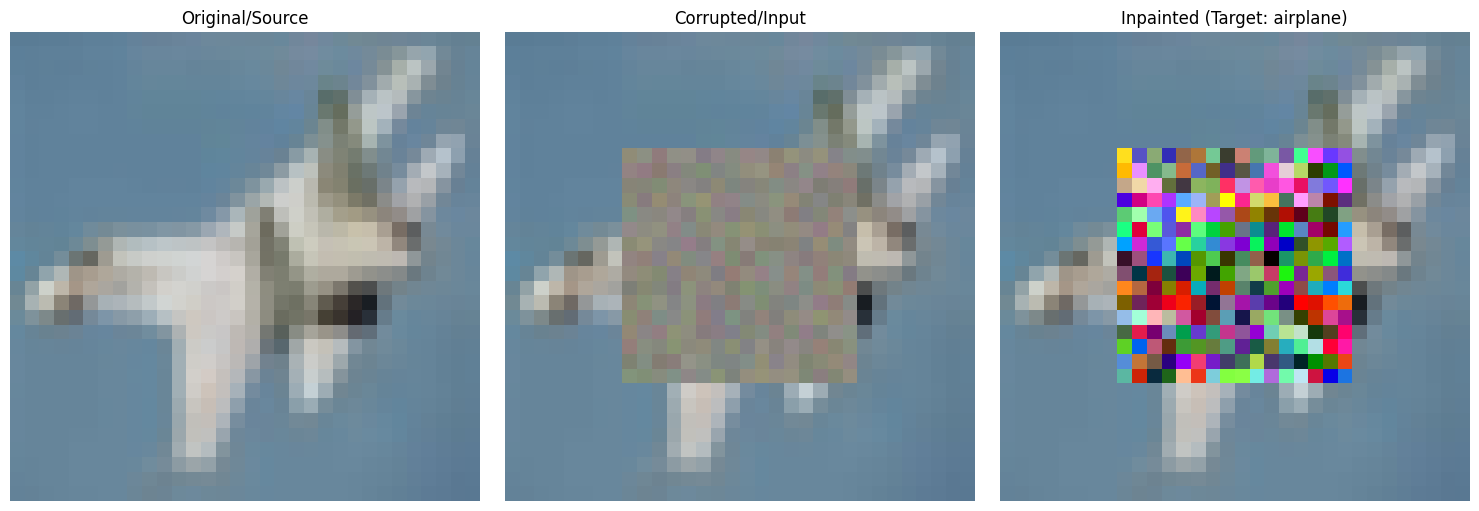

In [21]:
mask_tensor = torch.zeros_like(x_sample_norm).to(DEVICE)
mask_tensor[:, :, 8:24, 8:24] = 1.0 # 16x16 center mask
x_corrupted_norm = x_sample_norm.clone()
x_corrupted_norm.data = x_corrupted_norm.data * (1 - mask_tensor) + torch.rand_like(x_sample_norm) * mask_tensor * 0.5

lambda_reg_inpainting = 0.05
inpainted_result_norm = generate_inpainting_result(
    model, x_sample_norm, mask_tensor, y_sample_idx, lambda_reg_inpainting, NUM_STEPS, STEP_SIZE, DEVICE
)

x_corrupted_unnorm = denormalize(x_corrupted_norm[0])
inpainted_unnorm = denormalize(inpainted_result_norm[0])
show_images(x_sample_unnorm, inpainted_unnorm, corrupted_img=x_corrupted_unnorm, title=f"Inpainted (Target: {CIFAR_LABELS[y_sample_idx]})")


## 2. Image-to-Image Translation

Translation PGD to Class 3: 100%|██████████| 100/100 [00:00<00:00, 201.70it/s]


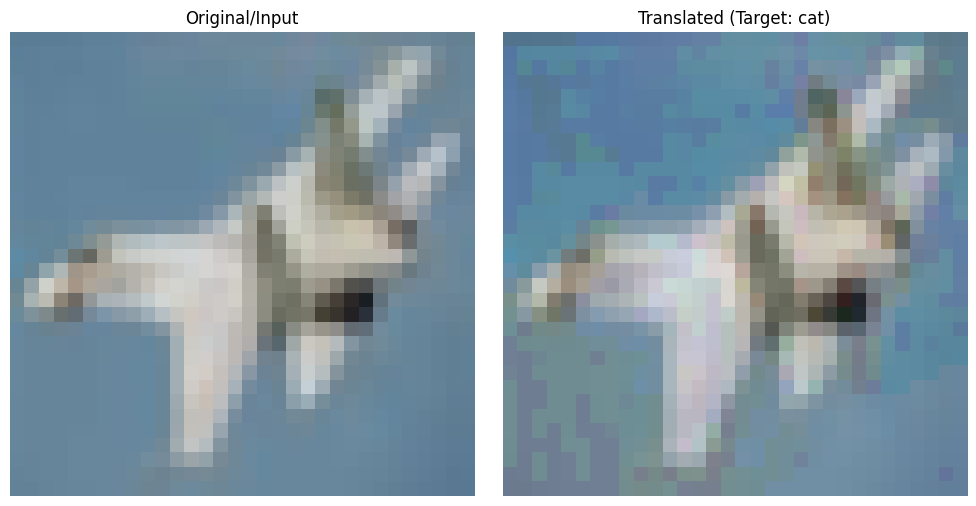

In [22]:

target_idx_trans = (y_sample_idx + 3) % 10 # Different target class
target_label_trans = CIFAR_LABELS[target_idx_trans]

epsilon_translation = (8.0/255.0) / torch.mean(std_tensor_dev).item()

translated_result_norm = generate_translation_result(
    model, x_sample_norm, target_idx_trans, epsilon_translation, NUM_STEPS, STEP_SIZE, DEVICE
)

translated_unnorm = denormalize(translated_result_norm[0])
show_images(x_sample_unnorm, translated_unnorm, title=f"Translated (Target: {target_label_trans})")



## 3. Super-Resolution

Super-Resolution PGD: 100%|██████████| 100/100 [00:00<00:00, 194.20it/s]


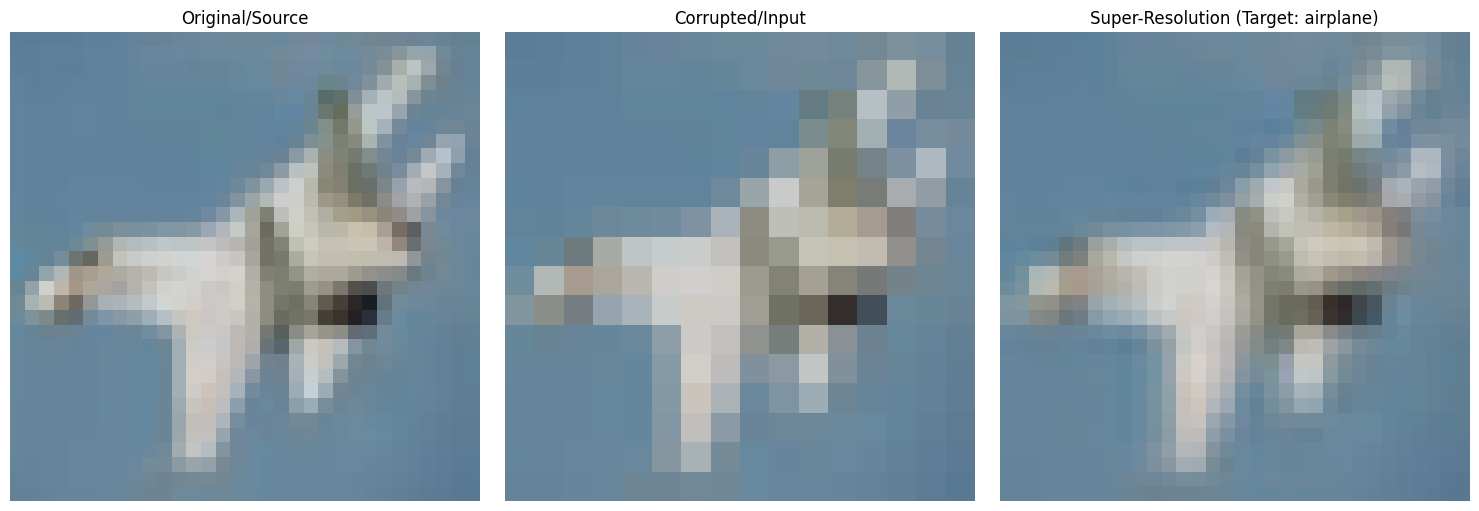

In [23]:
x_low_res_norm = downsample_cifar(x_sample_norm)
lambda_reg_sr = 1.0

super_res_result_norm = generate_super_resolution_result(
    model, x_low_res_norm, y_sample_idx, lambda_reg_sr, NUM_STEPS, STEP_SIZE, DEVICE
)

x_low_res_unnorm = denormalize(F.interpolate(x_low_res_norm, scale_factor=2, mode='nearest')[0])
super_res_unnorm = denormalize(super_res_result_norm[0])
show_images(x_sample_unnorm, super_res_unnorm, corrupted_img=x_low_res_unnorm, title=f"Super-Resolution (Target: {CIFAR_LABELS[y_sample_idx]})")



## 4. Generative Adversarial Examples

Adv. Example to Class 5: 100%|██████████| 100/100 [00:00<00:00, 199.61it/s]


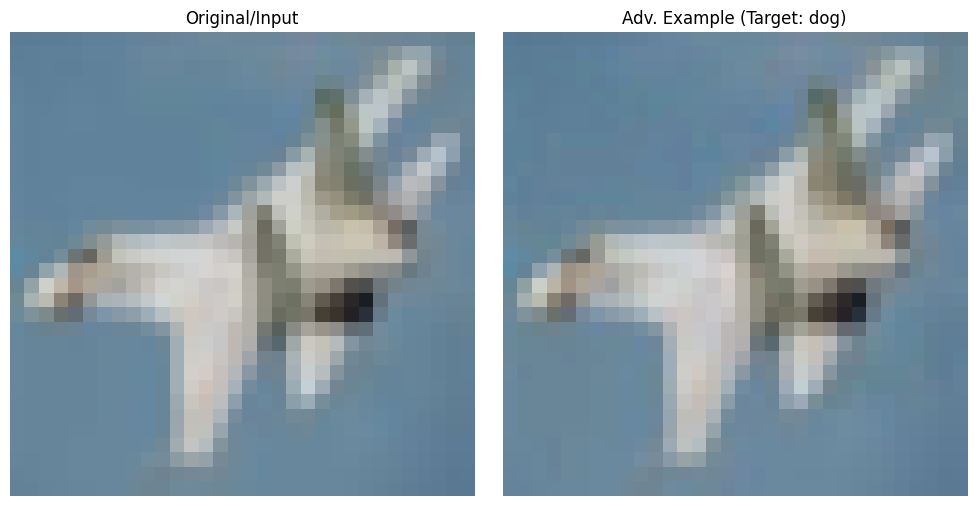

In [24]:
target_idx_adv = (y_sample_idx + 5) % 10 # Different target class
target_label_adv = CIFAR_LABELS[target_idx_adv]

epsilon_adv = (2.0/255.0) / torch.mean(std_tensor_dev).item()

adv_result_norm = generate_adversarial_example(
    model, x_sample_norm, target_idx_adv, epsilon_adv, NUM_STEPS, STEP_SIZE, DEVICE
)

adv_unnorm = denormalize(adv_result_norm[0])
show_images(x_sample_unnorm, adv_unnorm, title=f"Adv. Example (Target: {target_label_adv})")



## 5. Random Samples

Random Sample for Class 7: 100%|██████████| 100/100 [00:00<00:00, 153.48it/s]


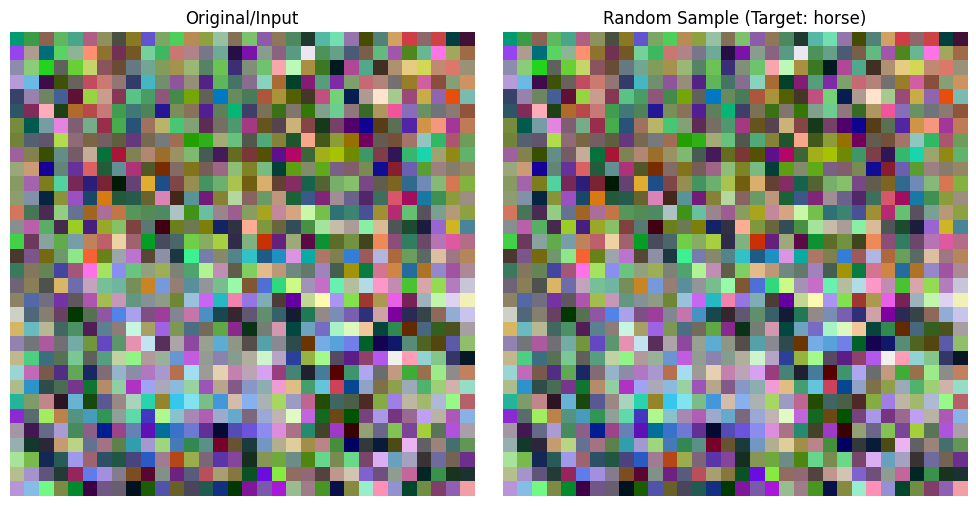

In [25]:
random_target_idx = 7 # Fixed target class (Horse)
random_target_label = CIFAR_LABELS[random_target_idx]

random_sample_norm = generate_random_sample(
    model,
    random_target_idx,
    NUM_STEPS,
    STEP_SIZE,
    DEVICE,
    'random'
)

random_sample_unnorm = denormalize(random_sample_norm[0])
show_images(random_sample_unnorm, random_sample_unnorm, corrupted_img=None, title=f"Random Sample (Target: {random_target_label})")